In [1]:
#data format library
import h5py

#numpy
import numpy as np
import pandas as pd
import numpy.ma as ma
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)
plt.rcParams["font.family"] = "Times New Roman"
# %matplotlib notebook
import sys
sys.path.append('/Users/gautam.sridhar/Documents/Repos/Markov_Fish/utils/')
import matplotlib.colors as pltcolors
import os
import copy
import clustering_methods as cl
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import time
import simulation_functions as sfs

np.random.seed(42)

In [2]:
path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data+'filtered_jmpool_kin.h5','r')
lengths = np.array(f['MetaData/lengths_data'],dtype=int)

X_head = ma.array(f['head_pos'])
phi_smooth = ma.array(f['orientation_smooth'])
f.close()

In [3]:
condition_labels = ['Light (5x5cm)','Light (1x5cm)','Looming(5x5cm)','Dark_Transitions(5x5cm)',
                    'Phototaxis','Optomotor Response (1x5cm)','Optokinetic Response (5x5cm)','Dark (5x5cm)','3 min Light<->Dark(5x5cm)',
                    'Prey Capture Param. (2.5x2.5cm)','Prey Capture Param. RW. (2.5x2.5cm)',
                    'Prey Capture Rot.(2.5x2.5cm)','Prey capture Rot. RW. (2.5x2.5cm)','Light RW. (2.5x2.5cm)']

condition_recs = np.array([[453,463],[121,133],[49,109],[22,49],[163,193],[109,121],
                           [133,164],[443,453],[0,22],
                           [193,258],[304,387],[258,273],[273,304],
                           [387,443]])

In [4]:
conditions = np.zeros((np.max(condition_recs),2),dtype='object')
for k in range(len(condition_recs)):
    t0,tf = condition_recs[k]
    conditions[t0:tf,0] = np.arange(t0,tf)
    conditions[t0:tf,1] = [condition_labels[k] for t in range(t0,tf)]

In [5]:
X_head[X_head == 0] = ma.masked

phi_smooth[phi_smooth == 0] = ma.masked

## Checking of level of thigmotactic behavior

In [6]:
pc = 365 #pix/cm
npc = 170 #pix/cm

pix_sizes = [npc,pc]

In [7]:
for cond in range(len(condition_labels)):
    print(condition_labels[cond])
    cond_recs = np.where(conditions[:,1] == condition_labels[cond])
    if cond < 9:
        X_head[cond_recs] = X_head[cond_recs]/pix_sizes[0]
    else:
        X_head[cond_recs] = X_head[cond_recs]/pix_sizes[1]

Light (5x5cm)
Light (1x5cm)
Looming(5x5cm)
Dark_Transitions(5x5cm)
Phototaxis
Optomotor Response (1x5cm)
Optokinetic Response (5x5cm)
Dark (5x5cm)
3 min Light<->Dark(5x5cm)
Prey Capture Param. (2.5x2.5cm)
Prey Capture Param. RW. (2.5x2.5cm)
Prey Capture Rot.(2.5x2.5cm)
Prey capture Rot. RW. (2.5x2.5cm)
Light RW. (2.5x2.5cm)


In [8]:
thresh = 0.1
ms = []
cils = []
cius = []
for cond in range(len(condition_labels)):
    cond_recs = np.where(conditions[:,1] == condition_labels[cond])
    print(condition_labels[cond])
    Xs = X_head[cond_recs]
    phis = phi_smooth[cond_recs]
    thig_ratio = []
    for kf in range(len(Xs)):
        sel = ~np.all(phis[kf].mask,axis=1)
        X_sample = Xs[kf][sel]
        Xmean = X_sample.mean(axis=1)
        xmin = Xmean[:,0].min()
        xmax = Xmean[:,0].max()
        ymin = Xmean[:,1].min()
        ymax = Xmean[:,1].max()

        sel = np.min(np.abs([Xmean[:,0]-xmin,Xmean[:,0]-xmax,Xmean[:,1]-ymin,Xmean[:,1]-ymax]),axis=0)<=thresh
        thig_ratio.append(len(np.where(sel == True)[0])/len(sel))
    m, cil, ciu = stats.bootstrap(thig_ratio, n_times=1000, n_samples=len(thig_ratio))
    ms.append(m)
    cils.append(ma.hstack(cil))
    cius.append(ma.hstack(ciu))

Light (5x5cm)
Light (1x5cm)
Looming(5x5cm)
Dark_Transitions(5x5cm)
Phototaxis
Optomotor Response (1x5cm)
Optokinetic Response (5x5cm)
Dark (5x5cm)
3 min Light<->Dark(5x5cm)
Prey Capture Param. (2.5x2.5cm)
Prey Capture Param. RW. (2.5x2.5cm)
Prey Capture Rot.(2.5x2.5cm)
Prey capture Rot. RW. (2.5x2.5cm)
Light RW. (2.5x2.5cm)


([<matplotlib.axis.XTick at 0x1329dc640>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

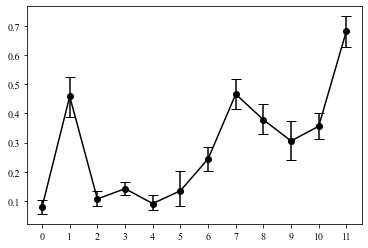

In [9]:
conds = [0,1,2,3,4,7,8,9,10,11,12,13]
# conds = np.arange(14)
plt.errorbar(np.arange(len(conds)), np.asarray(ms)[conds],[np.asarray(ms)[conds] - ma.hstack(cils)[conds], ma.hstack(cius)[conds] - np.asarray(ms)[conds]],
             capsize=5, marker='o', color='k')
plt.xticks(np.arange(len(conds)))
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl7/thigmotaxis.pdf')

In [10]:
def get_bootstrapped_probs(wall_orientation_fish,n_boot=1000,thresh=1/3.):
    nfish = len(wall_orientation_fish)
    ps_twd=np.zeros(n_boot)
    ps_agnst=np.zeros(n_boot)
    ps_parallel = np.zeros(n_boot)
    for k in range(n_boot):
        wos = np.hstack([wall_orientation_fish[kf] for kf in np.random.randint(0,nfish,nfish)])
        freqs,bin_edges = np.histogram(wos,bins = np.linspace(-1,1,100))
        centers = (bin_edges[1:]+bin_edges[:-1])/2
        ps_twd[k] = freqs[centers<-thresh].sum()/freqs.sum()
        ps_agnst[k] =  freqs[centers>thresh].sum()/freqs.sum()
        ps_parallel[k] =  freqs[np.logical_and(centers>=-thresh,centers<=thresh)].sum()/freqs.sum()
    return ps_twd,ps_agnst,ps_parallel

In [11]:
normal_vecs = [np.array([1,0]),np.array([-1,0]),np.array([0,1]),np.array([0,-1])]

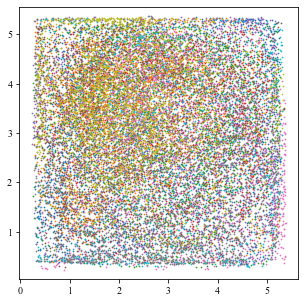

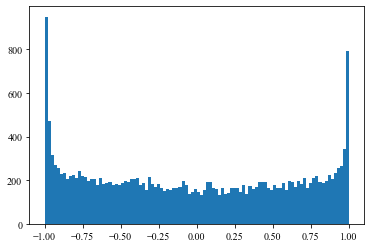

0.38788263357794794


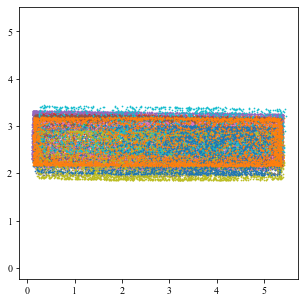

0.11231212401657961 5.362171487247243 2.0823165538699127 3.157772757790305
0.12534970896584646 5.416056315104167 2.1699737899604883 3.263929174580705
0.11971136301505465 5.366048039616765 2.103622101165436 3.1883730681046196
0.13647786523126493 5.380592836152523 2.1727684362610775 3.270128007368608
0.09918508435239887 5.399963710619056 2.2014912450036337 3.318930174175062
0.128886339957254 5.3957706866878095 2.155419575799372 3.2321686051849627
0.1292895542756292 5.37061767578125 2.054898701016865 3.1002147381122294
0.13933998107910156 5.380962262834822 1.932488952020202 2.964437148150276
0.17981014649073282 5.432283673967634 1.8495238417879156 2.9022977120535716
0.228038723185911 5.460541457272647 2.3817232690676295 3.4331018621271308
0.1302917813791812 5.372350869058561 1.9593398872463184 3.0259943423063858
0.11727574893406459 5.382957620823637 2.147233541032909 3.1926975139992773


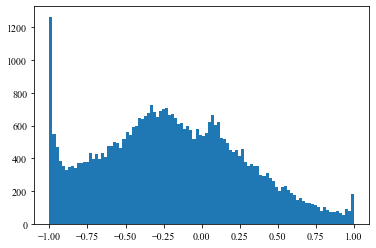

0.40337601540106327


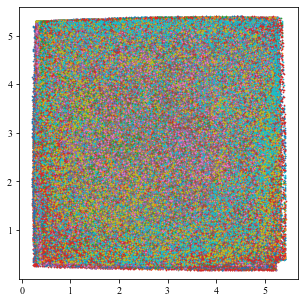

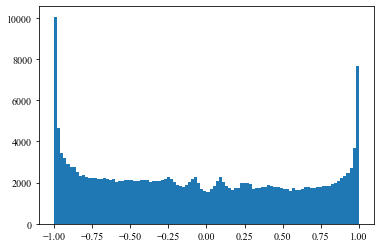

0.3937600621851278


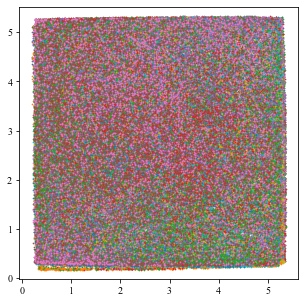

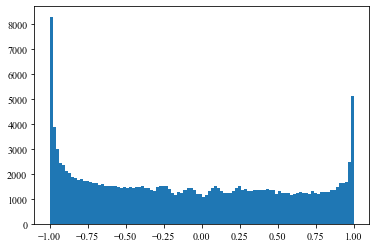

0.4113790162722433


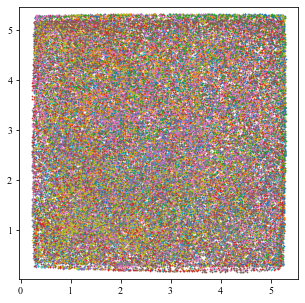

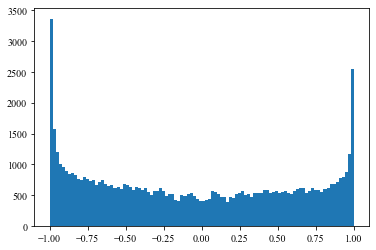

0.41597579633130044


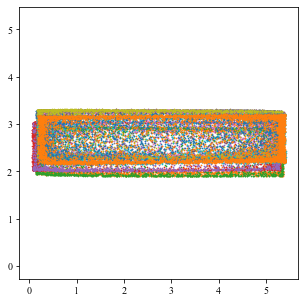

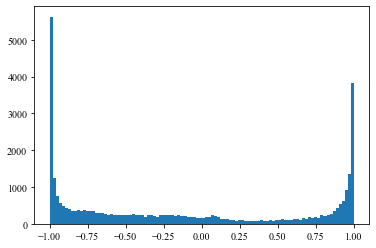

0.4914617189182258


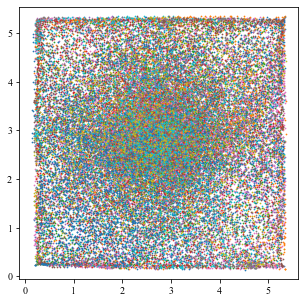

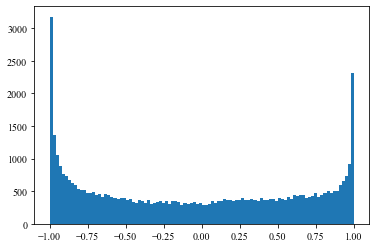

0.415553847370407


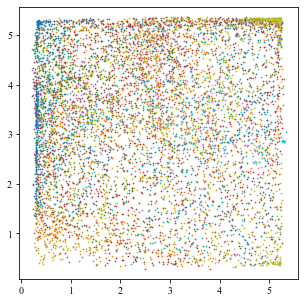

0.2653856822422573 5.255831821986607 0.3770299175985498 5.322034999302455
0.2704826881145609 5.2694142659505205 0.33382163109717433 5.336724609375
0.24030197333104863 4.55348388671875 0.4302008734809028 5.216314252638659
0.24598284827338324 5.263880920410156 0.2798712743471747 5.290546162923177
0.21733867645263671 4.998235174950133 0.3565567145913334 5.236332659040179
0.21590277206066044 5.22577564136402 0.37111699080266874 5.364618249841638
0.4244507876309482 5.067114370840567 1.6705726065286777 5.212641716003418
0.6166053989955357 5.305882309422349 1.0792957174366917 5.18836181640625
0.2634956481608939 5.2617225864955355 0.32899738180226296 5.372464725889008
0.34738162711814596 5.33441162109375 0.37246040503184 5.30176887512207


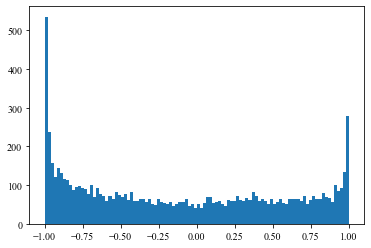

0.4474952174408506


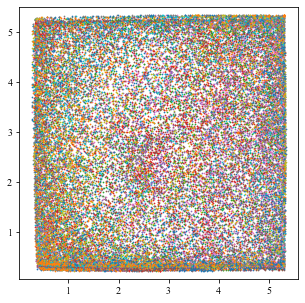

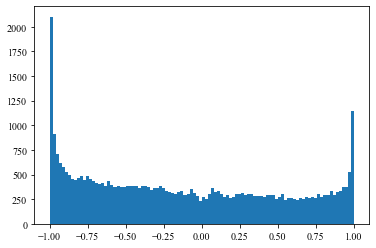

0.4427476525981325


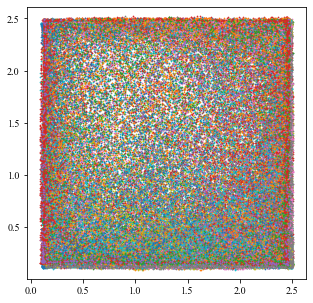

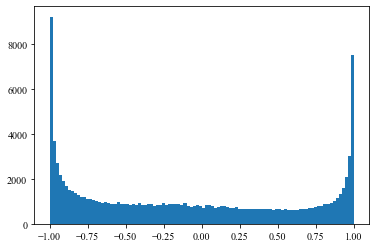

0.4408976518172003


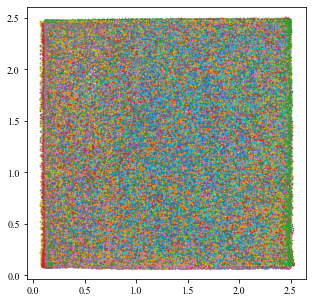

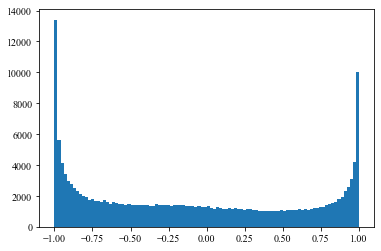

0.43747730762156584


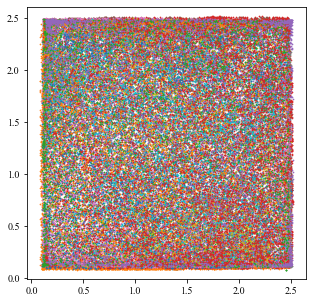

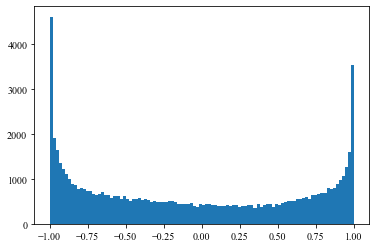

0.435947085254716


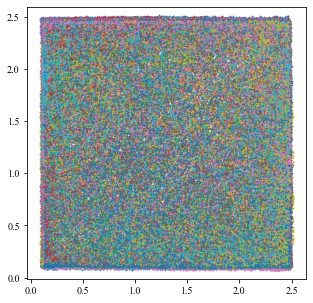

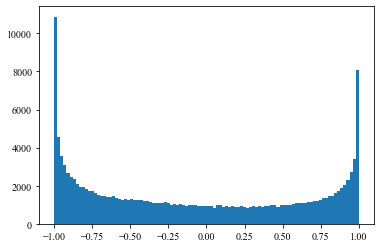

0.44722039081104326


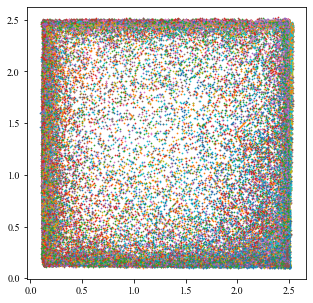

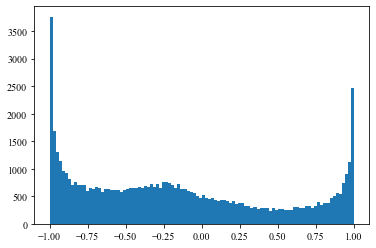

0.4593176662867865


In [12]:
condition_indices = [0,0,0,0,0,0,0,0,0,1,1,1,1,1]
n_boot=50
ps_twd_cond_ci = np.zeros((len(condition_labels),n_boot))
ps_agnst_cond_ci = np.zeros((len(condition_labels),n_boot))
ps_parallel_cond_ci = np.zeros((len(condition_labels),n_boot))
wo_fish = []
for kc in range(len(condition_labels)):
    
    cond_recs = np.where(conditions[:,1] == condition_labels[kc])
    Xs = X_head[cond_recs]
    phis = phi_smooth[cond_recs]

#     c0,cf = condition_recs[kc]
#     X_head = head_pos[c0:cf]
#     phis = orientations[c0:cf]
#     print(condition_labels[kc])
    
    
    plt.figure(figsize=(5,5))
    for kf in range(len(phis)):
        sel = ~np.all(phis[kf].mask,axis=1)
        phi_sample = phis[kf][sel]+np.pi
        X_sample = Xs[kf][sel]
        Xmean = X_sample.mean(axis=1)
        plt.scatter(Xmean[:,0],Xmean[:,1],s=.5)
    plt.axis('equal')
    plt.show()


    thresh = .1 # 1/4 body length measuring the head
    thresh_pix = thresh*pix_sizes[condition_indices[kc]]

    if kc==1 or kc==7:
        wall_orientation_fish=[]
        for kf in range(len(phis)):
            sel = ~np.all(phis[kf].mask,axis=1)
            phi_sample = phis[kf][sel]+np.pi
            X_sample = Xs[kf][sel]
            Xmean = X_sample.mean(axis=1)
            xmin = Xmean[:,0].min()
            xmax = Xmean[:,0].max()
            ymin = Xmean[:,1].min()
            ymax = Xmean[:,1].max()
            print(xmin,xmax,ymin,ymax)
            sel = np.min(np.abs([Xmean[:,0]-xmin,Xmean[:,0]-xmax,Xmean[:,1]-ymin,Xmean[:,1]-ymax]),axis=0)<=thresh_pix
            phi_last = [phi_sample[kb].compressed()[-20:].mean() for kb in range(len(phi_sample))]
            Xv = np.vstack([np.cos(phi_last),np.sin(phi_last)]).T
            X_wall = Xmean[sel]
            Xv_wall = Xv[sel]
            wall_orientation = []
            for kb in range(X_wall.shape[0]):    
                idx = np.argmin(np.abs([Xmean[kb,0]-xmin,Xmean[kb,0]-xmax,Xmean[kb,1]-ymin,Xmean[kb,1]-ymax]))
                wall_orientation.append(Xv[kb].dot(normal_vecs[idx]))
            wall_orientation_fish.append(wall_orientation)

        plt.hist(np.hstack(wall_orientation_fish),bins=100)
        plt.show()

        ps_twd,ps_agnst,ps_parallel = get_bootstrapped_probs(wall_orientation_fish,n_boot)
#         ps_twd,ps_agnst =  get_bootstrapped_probs(wall_orientation_fish,n_boot)
#         ps_twd_ci = np.hstack(stats.bootstrap(ps_twd,n_times=100))
#         ps_agnst_ci = np.hstack(stats.bootstrap(ps_agnst,n_times=100))

#         print(ps_twd_ci,ps_agnst_ci)


    else:
        xmin=0
        xmax=5
        ymin=0
        ymax=5
        wall_orientation_fish=[]
        for kf in range(len(phis)):
            sel = ~np.all(phis[kf].mask,axis=1)
            phi_sample = phis[kf][sel]+np.pi
            X_sample = Xs[kf][sel]
            Xmean = X_sample.mean(axis=1)
            sel = np.min(np.abs([Xmean[:,0]-xmin,Xmean[:,0]-xmax,Xmean[:,1]-ymin,Xmean[:,1]-ymax]),axis=0)<=thresh_pix
            phi_last = [phi_sample[kb].compressed()[-20:].mean() for kb in range(len(phi_sample))]
            Xv = np.vstack([np.cos(phi_last),np.sin(phi_last)]).T
            X_wall = Xmean[sel]
            Xv_wall = Xv[sel]
            wall_orientation = []
            for kb in range(X_wall.shape[0]):    
                idx = np.argmin(np.abs([Xmean[kb,0]-xmin,Xmean[kb,0]-xmax,Xmean[kb,1]-ymin,Xmean[kb,1]-ymax]))
                wall_orientation.append(Xv[kb].dot(normal_vecs[idx]))
            wall_orientation_fish.append(wall_orientation)

        plt.hist(np.hstack(wall_orientation_fish),bins=100)
        plt.show()
        ps_twd,ps_agnst,ps_parallel = get_bootstrapped_probs(wall_orientation_fish,n_boot)

#         ps_twd,ps_agnst = get_bootstrapped_probs(wall_orientation_fish,n_boot)
    print(ps_twd.mean())

#         print(ps_twd_ci,ps_agnst_ci)
    ps_twd_cond_ci[kc] = ps_twd
    ps_agnst_cond_ci[kc] = ps_agnst
    ps_parallel_cond_ci[kc] = ps_parallel
    wo_fish.append(np.hstack(wall_orientation_fish))


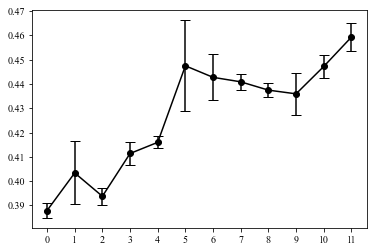

In [14]:
conds = [0,1,2,3,4,7,8,9,10,11,12,13]
# plt.figure(figsize=(15,5))
plt.errorbar(np.arange(len(conds)),ps_twd_cond_ci.mean(axis=1)[conds],yerr = ps_twd_cond_ci.std(axis=1)[conds],capsize=5,marker='o',c='k')
plt.xticks(np.arange(len(conds)))
# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl7/Prob_against.pdf')
plt.show()

In [15]:
## Load symbolic sequences

path_to_filtered_data = '/Users/gautam.sridhar/Documents/Repos/Markov_Fish/Datasets/JM_Data/'
f = h5py.File(path_to_filtered_data + 'kmeans_labels_K5_N1200_s8684.h5')
lengths_all = np.array(f['MetaData/lengths_data'], dtype=int)
labels_fish = ma.array(f['labels_fish'],dtype=int)
state_trajs = ma.array(f['state_trajs'])
f.close()

In [16]:
to_mask = 1300
maxL = np.max(lengths_all)

labels_fish[labels_fish == to_mask] = ma.masked
labels_all = ma.concatenate(labels_fish, axis=0)

In [18]:
P_ensemble = np.load(path_to_filtered_data+'/P_ensemble_ex8_N1200_s8684.npy')

In [19]:
from scipy.sparse import diags,identity,coo_matrix, csr_matrix
P_ensemble = csr_matrix(P_ensemble)

lcs_ensemble = msm_estimation.largest_connected_set(P_ensemble)
inv_measure = op_calc.stationary_distribution(P_ensemble)
final_labels = op_calc.get_connected_labels(labels_all,lcs_ensemble)

In [20]:
# Load eigenfunctions

# eigfunctions = np.load(path_to_filtered_data + 'eigfs_n1200.npy')
phi1 = eigfunctions[:,1]
phi2 = eigfunctions[:,2]
phi3 = eigfunctions[:,3]

# Uncomment to discover eigenfunctions and eigenvalues from ensemble transition matrix. 
# The estimation of eigenvalues is done through ARPACK, which is stochastic in nature. 
# This can result in the eigenvectors flipping sign. 
# If that happens, you can change the random seed in op_calc.sorted_spectrum()

# from scipy.sparse import diags,identity,coo_matrix, csr_matrix
# P_ensemble = csr_matrix(P_ensemble)

# import msmtools.estimation as msm_estimation
# delay = 3
# dt = 1
# print(delay)
# # lcs_ensemble,P_ensemble = op_calc.transition_matrix(labels_all,delay,return_connected=True)
# R = op_calc.get_reversible_transition_matrix(P_ensemble)
# eigvals,eigvecs = op_calc.sorted_spectrum(R,k=10,seed=123) 
# sorted_indices = np.argsort(eigvals.real)[::-1]
# eigvals = eigvals[sorted_indices][1:].real
# eigvals[np.abs(eigvals-1)<1e-12] = np.nan
# eigvals[eigvals<1e-12] = np.nan
# t_imp =  -(delay*dt)/np.log(np.abs(eigvals))
# eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
# eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
# eigfunctions_traj[final_labels.mask] = ma.masked

In [21]:
coh_labels_phi1 = np.load(path_to_filtered_data + 'cg2_labels.npy')

In [22]:
cluster_traj = ma.array(coh_labels_phi1)[final_labels]
cluster_traj[final_labels.mask] = ma.masked

In [23]:
ctraj_fish = cluster_traj.reshape(labels_fish.shape[0],labels_fish.shape[1])

In [25]:
X_head = X_head[:,:maxL,:]

In [26]:
nbins=25

condition_indices = np.arange(len(conditions))[conditions[:,1]==condition_labels[13]]
xmin = ma.hstack(X_head[condition_indices][:,:,0]).min()
xmax = ma.hstack(X_head[condition_indices][:,:,0]).max()
bins = np.linspace(xmin,xmax,nbins+1)
wandering_fracs_l = ma.zeros((len(condition_indices),nbins))
cruising_fracs_l = ma.zeros((len(condition_indices),nbins))
for k_,k in enumerate(condition_indices):
    X = X_head[k][:,0]
    counts,edges = np.histogram(X_head[k][:,0].compressed(),bins)
    counts_wandering,edges = np.histogram(X_head[k][:,0][ctraj_fish[k]==0].compressed(),bins)
    counts_cruising,edges = np.histogram(X_head[k][:,0][ctraj_fish[k]==1].compressed(),bins)
    sel = counts>0
    wandering_fracs_l[k_,sel] = counts_wandering[sel]/counts[sel]
    cruising_fracs_l[k_,sel] = counts_cruising[sel]/counts[sel]
    wandering_fracs_l[k_,~sel] = ma.masked
    cruising_fracs_l[k_,~sel] = ma.masked

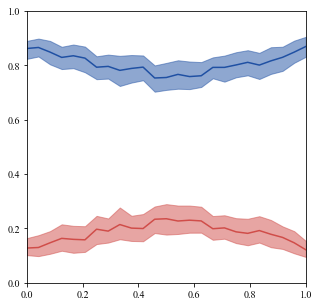

In [27]:
colors_states_ = ['#1F50A3','#D04D49']
plt.figure(figsize=(5,5))
mean,cil,ciu=stats.bootstrap(wandering_fracs_l,n_times=100)
plt.plot(np.linspace(0,1,nbins),mean,colors_states_[0])
plt.fill_between(np.linspace(0,1,nbins),cil,ciu,color=colors_states_[0],alpha=.5)
mean,cil,ciu=stats.bootstrap(cruising_fracs_l,n_times=100)
plt.plot(np.linspace(0,1,nbins),mean,colors_states_[1])
plt.fill_between(np.linspace(0,1,nbins),cil,ciu,color=colors_states_[1],alpha=.5)
plt.ylim(0,1)
plt.xlim(0,1)

# plt.savefig('/Users/gautam.sridhar/Documents/ZENITH/Figures/Suppl7/lightrw_wallbeh.pdf')
plt.show()